In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# DNN

In [2]:
df = pd.read_csv(r"Data/df_alemania_final.csv")

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df = df.fillna(0)

In [5]:
df.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Simple Date    0
Hour           0
dtype: int64

In [6]:
df

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,0.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,0.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,0.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,0.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,0.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,7000.0,13056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,2149.0,13078.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,276.0,14354.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,0.0,16051.0,2023-05-31,22


In [7]:
df['Exogenous 2'] = df['Exogenous 2'] + df['Exogenous 3']
df = df.drop(['Exogenous 3'], axis = 1)

In [8]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [9]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,20056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,15227.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,14630.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,16051.0,2023-05-31,22


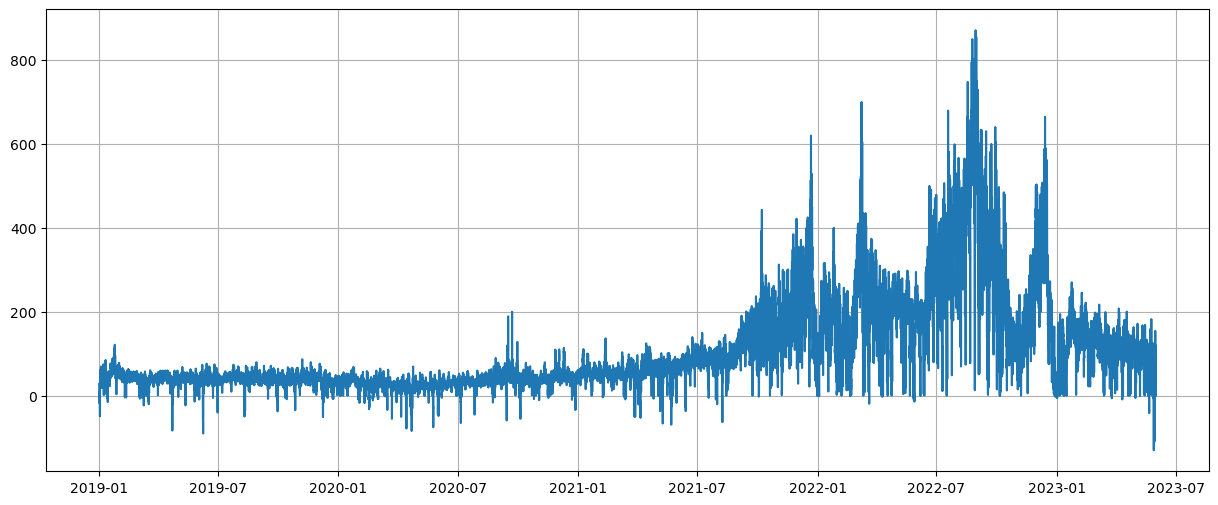

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [11]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [12]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [13]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

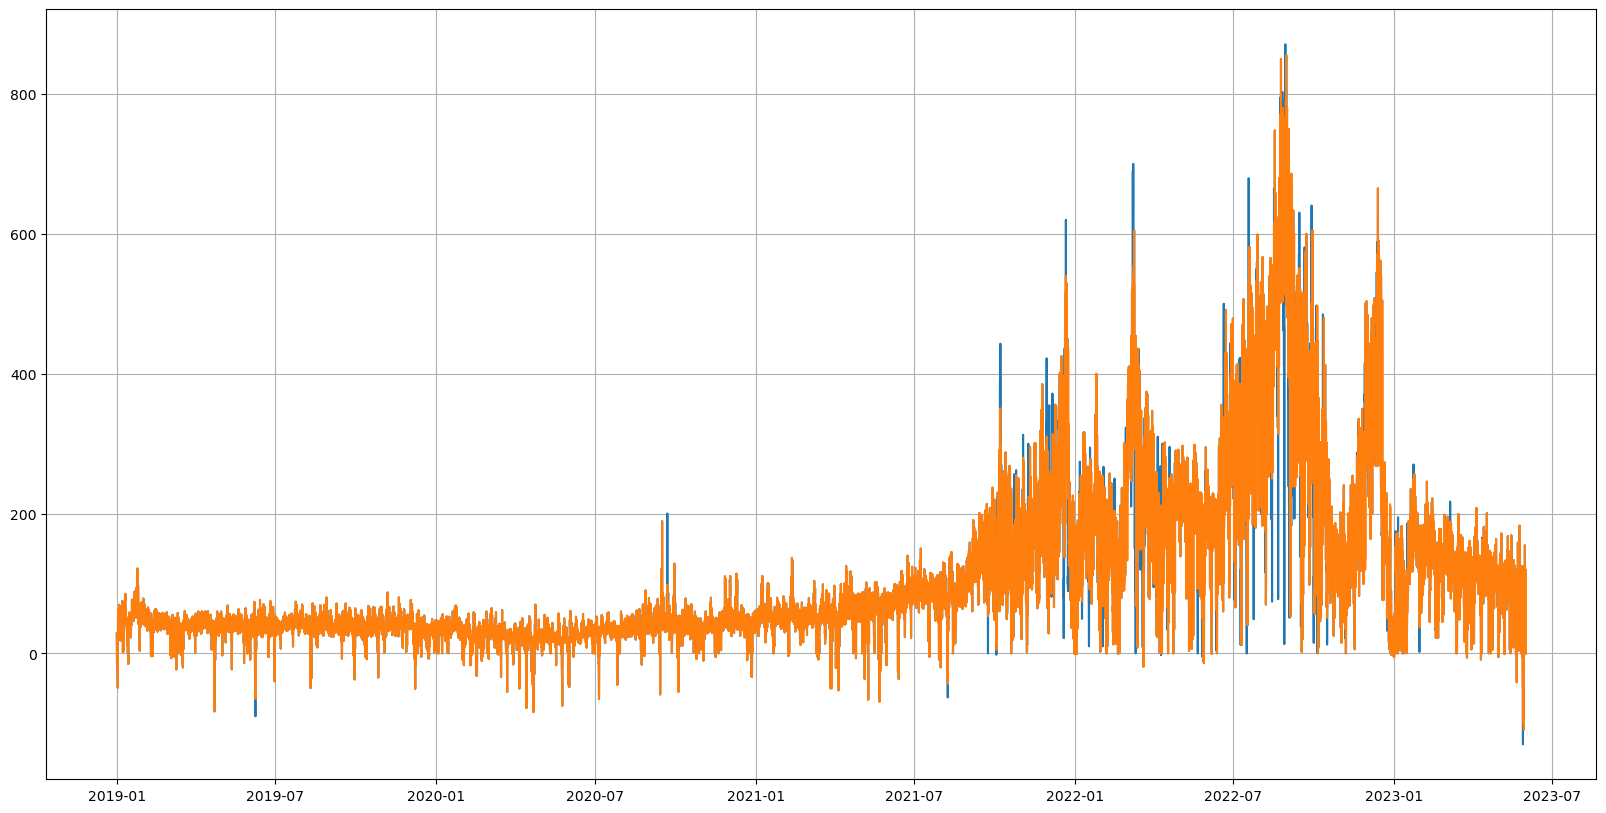

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [15]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [16]:
df.index = df.Date

In [17]:
df = df.drop(['Date'], axis = 1)

In [18]:
df_train = df[df.index < dt.datetime(2022, 1, 1)]
df_test = df[df.index >= dt.datetime(2022, 1, 1)]

In [19]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [20]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [21]:
forecast_dates = forecast.index

In [22]:
df_original = pd.read_csv(r"Data\df_alemania_final.csv")

In [23]:
df_original['Date'] = pd.to_datetime(df_original.Date)
df_original['Simple Date'] = df_original.Date.dt.strftime("%Y-%m-%d")
df_original['Hour'] = df_original.Date.dt.hour

In [24]:
df_original = df_original.fillna(0)

In [25]:
df_original.isna().sum()

Date           0
Price          0
Exogenous 1    0
Exogenous 2    0
Exogenous 3    0
Simple Date    0
Hour           0
dtype: int64

In [26]:
df_original

,Date,Price,Exogenous 1,Exogenous 2,Exogenous 3,Simple Date,Hour
0,2019-01-01 00:00:00,28.32,44216.0,0.0,23266.0,2019-01-01,0
1,2019-01-01 01:00:00,10.07,42397.0,0.0,25111.0,2019-01-01,1
2,2019-01-01 02:00:00,-4.08,40788.0,0.0,26717.0,2019-01-01,2
3,2019-01-01 03:00:00,-9.91,40307.0,0.0,28512.0,2019-01-01,3
4,2019-01-01 04:00:00,-7.41,40479.0,0.0,29911.0,2019-01-01,4
...,...,...,...,...,...,...,...
38683,2023-05-31 19:00:00,108.26,57968.0,7000.0,13056.0,2023-05-31,19
38684,2023-05-31 20:00:00,119.60,56582.0,2149.0,13078.0,2023-05-31,20
38685,2023-05-31 21:00:00,103.69,54087.0,276.0,14354.0,2023-05-31,21
38686,2023-05-31 22:00:00,94.28,51883.0,0.0,16051.0,2023-05-31,22


In [27]:
df_original['Exogenous 2'] = df_original['Exogenous 2'] + df_original['Exogenous 3']
df_original = df_original.drop(['Exogenous 3'], axis = 1)

In [28]:
df_original.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [29]:
df_original.index = df_original.Date

In [30]:
df_original = df_original.drop('Date', axis = 1)

In [31]:
df_original = df_original.drop(['Simple Date', 'Hour'], axis = 1)

In [32]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [33]:
df_original = df_original[df_original.index >= dt.datetime(2022, 1, 1)]

In [34]:
real_values = df_original[df_original.index >= dt.datetime(2022, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [35]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,50.05,41.33,43.22,45.46,37.67,39.70,40.59,43.26,49.66,70.05,...,97.17,101.00,126.60,149.97,146.33,140.28,121.88,102.61,97.46,85.16
2022-01-02,57.08,52.59,48.97,34.94,29.56,33.97,34.52,41.80,48.95,60.01,...,40.01,29.11,32.76,42.97,60.96,60.94,54.12,46.16,46.29,32.93
2022-01-03,0.31,-0.01,-0.07,-1.05,-1.00,0.32,37.55,88.76,122.93,110.17,...,80.99,98.05,123.51,148.49,138.00,117.64,117.71,95.95,105.68,95.26
2022-01-04,103.70,108.27,105.92,103.41,102.71,114.23,156.91,182.64,178.91,190.00,...,179.00,180.93,166.69,189.88,184.94,178.99,156.12,140.92,137.92,97.56
2022-01-05,105.31,97.29,84.50,75.38,79.11,94.79,99.16,101.15,129.56,113.37,...,107.32,119.48,137.28,148.09,139.88,135.75,119.93,98.09,118.71,99.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,89.69,83.53,84.73,86.33,91.25,90.00,82.70,82.99,72.61,55.06,...,-2.39,0.51,2.26,55.08,84.85,100.38,124.93,113.08,100.03,94.71
2023-05-28,87.09,84.00,81.92,77.87,77.86,76.47,72.02,64.84,37.70,0.00,...,-129.96,-98.08,-18.68,-0.06,50.00,72.90,80.01,77.84,73.80,69.50
2023-05-29,59.23,53.90,51.82,48.51,54.52,63.36,67.65,58.71,29.92,0.00,...,-109.45,-80.69,-19.97,-4.98,19.20,72.08,83.75,85.88,80.48,74.26


In [36]:
forecast_dates = forecast.index

In [37]:
from epftoolbox.models import hyperparameter_optimizer

In [38]:
df.to_csv("Data/df_alemania_dnn_no_outliers.csv")

In [39]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "df_alemania_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = 3

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00


Tested 1/100 iterations.
Best MAE - Validation Dataset
  MAE: 12.5 | sMAPE: 25.81 %

Best MAE - Test Dataset
  MAE: 49.1 | sMAPE: 30.29 %


Tested 2/100 iterations.
Best MAE - Validation Dataset
  MAE: 12.5 | sMAPE: 25.81 %

Best MAE - Test Dataset
  MAE: 49.1 | sMAPE: 30.29 %


Tested 3/100 iterations.
Best MAE - Validation Dataset
  MAE: 12.5 | sMAPE: 25.81 %

Best MAE - Test Dataset
  MAE: 49.1 | sMAPE: 30.29 %


Tested 4/100 iterations.
Best MAE - Validation Dataset
  MAE: 12.5 | sMAPE: 25.81 %

Best MAE - Test Dataset
  MAE: 49.1 | sMAPE: 30.29 %


Tested 5/100 iterations.
Best MAE - Validation Dataset
  MAE: 12.5 | sMAPE: 25.81 %

Best MAE - Test Dataset
  MAE: 49.1 | sMAPE: 30.29 %


Tested 6/100 iterations.
Best MAE - Validation Dataset
  MAE: 12.5 | sMAPE: 25.81 %

Best MAE - Test Dataset
  MAE: 49.1 | sMAPE: 30.29 %


Tested 7/100 iterations.
Best MAE - Validation Dataset
  MAE: 12.5 | sMAPE: 25.81 %

Best MAE - Test 



Tested 59/100 iterations.
Best MAE - Validation Dataset
  MAE: 9.0 | sMAPE: 18.52 %

Best MAE - Test Dataset
  MAE: 42.7 | sMAPE: 27.57 %


Tested 60/100 iterations.
Best MAE - Validation Dataset
  MAE: 9.0 | sMAPE: 18.52 %

Best MAE - Test Dataset
  MAE: 42.7 | sMAPE: 27.57 %


Tested 61/100 iterations.
Best MAE - Validation Dataset
  MAE: 9.0 | sMAPE: 18.52 %

Best MAE - Test Dataset
  MAE: 42.7 | sMAPE: 27.57 %


Tested 62/100 iterations.
Best MAE - Validation Dataset
  MAE: 9.0 | sMAPE: 18.52 %

Best MAE - Test Dataset
  MAE: 42.7 | sMAPE: 27.57 %


Tested 63/100 iterations.
Best MAE - Validation Dataset
  MAE: 9.0 | sMAPE: 18.52 %

Best MAE - Test Dataset
  MAE: 42.7 | sMAPE: 27.57 %


Tested 64/100 iterations.
Best MAE - Validation Dataset
  MAE: 9.0 | sMAPE: 18.52 %

Best MAE - Test Dataset
  MAE: 42.7 | sMAPE: 27.57 %


Tested 65/100 iterations.
Best MAE - Validation Dataset
  MAE: 9.0 | sMAPE: 18.52 %

Best MAE - Test Dataset
  MAE: 42.7 | sMAPE: 27.57 %


Tested 66/100 iter

In [40]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "df_alemania_dnn_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_alemania_final_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = 3
experiment_id = 1

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00
2022-01-01 - sMAPE: 90.65%  |  MAE: 51.503
2022-01-02 - sMAPE: 75.23%  |  MAE: 45.834
2022-01-03 - sMAPE: 74.38%  |  MAE: 39.721
2022-01-04 - sMAPE: 63.74%  |  MAE: 38.538
2022-01-05 - sMAPE: 55.01%  |  MAE: 35.793
2022-01-06 - sMAPE: 50.89%  |  MAE: 36.492
2022-01-07 - sMAPE: 47.78%  |  MAE: 37.755
2022-01-08 - sMAPE: 43.44%  |  MAE: 35.606
2022-01-09 - sMAPE: 40.56%  |  MAE: 34.316
2022-01-10 - sMAPE: 38.75%  |  MAE: 35.166
2022-01-11 - sMAPE: 35.67%  |  MAE: 32.957
2022-01-12 - sMAPE: 33.30%  |  MAE: 31.767
2022-01-13 - sMAPE: 32.25%  |  MAE: 32.477
2022-01-14 - sMAPE: 30.58%  |  MAE: 31.330
2022-01-15 - sMAPE: 29.11%  |  MAE: 30.344
2022-01-16 - sMAPE: 29.11%  |  MAE: 31.718
2022-01-17 - sMAPE: 29.96%  |  MAE: 34.665
2022-01-18 - sMAPE: 29.16%  |  MAE: 34.553
2022-01-19 - sMAPE: 28.26%  |  MAE: 33.927
2022-01-20 - sMAPE: 28.31%  |  MAE: 34.244
2022-01-21 - sMAPE: 27.54%  |  MAE: 33.568
2022-01-22 - sMAPE: 26.86%  |  MAE: 33.0

2022-07-10 - sMAPE: 22.62%  |  MAE: 31.506
2022-07-11 - sMAPE: 22.57%  |  MAE: 31.549
2022-07-12 - sMAPE: 22.51%  |  MAE: 31.591
2022-07-13 - sMAPE: 22.45%  |  MAE: 31.574
2022-07-14 - sMAPE: 22.36%  |  MAE: 31.494
2022-07-15 - sMAPE: 22.32%  |  MAE: 31.572
2022-07-16 - sMAPE: 22.30%  |  MAE: 31.698
2022-07-17 - sMAPE: 22.38%  |  MAE: 31.941
2022-07-18 - sMAPE: 22.31%  |  MAE: 31.935
2022-07-19 - sMAPE: 22.25%  |  MAE: 31.955
2022-07-20 - sMAPE: 22.22%  |  MAE: 32.069
2022-07-21 - sMAPE: 22.15%  |  MAE: 32.083
2022-07-22 - sMAPE: 22.11%  |  MAE: 32.171
2022-07-23 - sMAPE: 22.05%  |  MAE: 32.193
2022-07-24 - sMAPE: 22.04%  |  MAE: 32.311
2022-07-25 - sMAPE: 21.97%  |  MAE: 32.267
2022-07-26 - sMAPE: 21.95%  |  MAE: 32.361
2022-07-27 - sMAPE: 21.90%  |  MAE: 32.418
2022-07-28 - sMAPE: 21.88%  |  MAE: 32.628
2022-07-29 - sMAPE: 21.82%  |  MAE: 32.682
2022-07-30 - sMAPE: 21.80%  |  MAE: 32.790
2022-07-31 - sMAPE: 21.73%  |  MAE: 32.752
2022-08-01 - sMAPE: 21.67%  |  MAE: 32.755
2022-08-02 

2023-01-17 - sMAPE: 22.16%  |  MAE: 34.503
2023-01-18 - sMAPE: 22.14%  |  MAE: 34.479
2023-01-19 - sMAPE: 22.10%  |  MAE: 34.414
2023-01-20 - sMAPE: 22.07%  |  MAE: 34.370
2023-01-21 - sMAPE: 22.04%  |  MAE: 34.327
2023-01-22 - sMAPE: 22.00%  |  MAE: 34.258
2023-01-23 - sMAPE: 21.96%  |  MAE: 34.210
2023-01-24 - sMAPE: 21.92%  |  MAE: 34.157
2023-01-25 - sMAPE: 21.90%  |  MAE: 34.147
2023-01-26 - sMAPE: 21.87%  |  MAE: 34.106
2023-01-27 - sMAPE: 21.83%  |  MAE: 34.053
2023-01-28 - sMAPE: 21.81%  |  MAE: 34.010
2023-01-29 - sMAPE: 21.80%  |  MAE: 33.982
2023-01-30 - sMAPE: 21.83%  |  MAE: 33.970
2023-01-31 - sMAPE: 21.85%  |  MAE: 33.965
2023-02-01 - sMAPE: 21.85%  |  MAE: 33.918
2023-02-02 - sMAPE: 21.82%  |  MAE: 33.864
2023-02-03 - sMAPE: 21.82%  |  MAE: 33.835
2023-02-04 - sMAPE: 21.79%  |  MAE: 33.774
2023-02-05 - sMAPE: 21.77%  |  MAE: 33.740
2023-02-06 - sMAPE: 21.73%  |  MAE: 33.691
2023-02-07 - sMAPE: 21.73%  |  MAE: 33.694
2023-02-08 - sMAPE: 21.70%  |  MAE: 33.649
2023-02-09 

In [41]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,11.71589,8.458328,6.553914,5.109874,8.696094,12.438584,13.468301,21.378786,33.207481,41.301929,...,44.215111,46.689163,51.01186,56.93631,58.720741,54.598896,48.06031,40.934681,42.71368,36.289482
2022-01-02,89.024368,83.44323,78.61277,69.50573,69.120651,76.324417,81.689857,95.016182,105.945786,105.457306,...,74.935989,82.118347,91.45153,107.159462,112.548111,109.75428,96.631966,83.284592,81.976143,66.057861
2022-01-03,28.950527,26.706757,21.892504,18.126228,24.711594,37.489929,54.548779,74.922188,82.928543,78.047226,...,70.049629,75.754051,78.597618,90.17482,90.091637,86.874771,77.033401,71.467537,71.832397,60.501125
2022-01-04,90.041168,86.016724,83.414223,77.40184,81.579987,92.64624,108.414627,141.141724,154.801331,150.576355,...,126.333641,132.247437,141.501816,162.634109,163.037033,156.751663,136.531097,119.048019,115.454933,102.222977
2022-01-05,87.950798,84.384926,75.576988,68.704292,75.419975,96.473152,119.581879,158.141983,174.774338,168.394653,...,129.365662,143.104477,152.51004,175.10257,172.191452,158.131622,132.307114,113.445511,108.754654,90.768684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,85.085495,76.112366,72.451714,71.103516,70.525009,70.014351,70.152145,71.281181,67.221169,59.876587,...,19.751476,24.042822,35.870647,55.690498,77.309105,93.673386,101.402939,99.408623,94.390564,85.855591
2023-05-28,92.315704,80.547478,75.611542,71.848129,70.677727,68.15152,61.962467,56.963711,50.131866,38.875687,...,-13.284238,-6.50742,10.192816,31.865788,63.360409,81.190445,86.627708,88.882462,90.253738,80.438454
2023-05-29,58.596912,48.470901,47.084846,44.011734,42.749729,42.190002,41.445549,40.254902,34.016579,29.560997,...,-15.451109,-7.853909,5.053307,23.587744,47.605042,64.558777,72.299507,78.834724,76.488121,69.410202


In [42]:
forecast.to_csv("Resultados/dnn_alemania_final_no_outliers.csv")

# DNN + Estandarización móvil

In [44]:
with open('dict_new_df_alemania_final_no_outliers.pkl', 'rb') as handle:
    dict_new_df = pickle.load(handle)

In [45]:
df_nuevo = pd.DataFrame(dict_new_df)

In [46]:
df_nuevo['Date'] = pd.to_datetime(df_nuevo.Date)

In [47]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler']})

In [48]:
df_scalers

,Date,scaler
0,2019-01-08 00:00:00,StandardScaler()
1,2019-01-08 01:00:00,StandardScaler()
2,2019-01-08 02:00:00,StandardScaler()
3,2019-01-08 03:00:00,StandardScaler()
4,2019-01-08 04:00:00,StandardScaler()
...,...,...
38515,2023-05-31 19:00:00,StandardScaler()
38516,2023-05-31 20:00:00,StandardScaler()
38517,2023-05-31 21:00:00,StandardScaler()
38518,2023-05-31 22:00:00,StandardScaler()


In [49]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']]

In [50]:
df_nuevo.columns = ['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']

In [51]:
df_nuevo = df_nuevo.set_index('Date')

In [52]:
df_nuevo.to_csv("Data/alemania_dnn_estandarizacion_movil_no_outliers.csv")

In [53]:
from epftoolbox.models import hyperparameter_optimizer

In [54]:
# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = "alemania_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = None

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 2

# Number of iterations for hyperparameter optimization
max_evals = 100

path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00


Tested 1/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.30 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 2/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.30 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 3/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.30 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 4/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.30 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 5/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.30 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 6/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.30 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 7/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 69.30 %

Best MAE - Test Dataset
  MAE



Tested 60/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 67.96 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 61/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 67.96 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 62/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 67.96 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 63/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 67.96 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 64/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 67.96 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 65/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 67.96 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 66/100 iterations.
Best MAE - Validation Dataset
  MAE: 0.4 | sMAPE: 67.96 %

Best MAE - Test Dataset
  MAE: 0.5 | sMAPE: 82.79 %


Tested 67/100 iterations.

In [55]:
"""
Example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

import pandas as pd
import numpy as np
import argparse
import os

from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN


path_datasets_folder = "./Data/"
path_hyperparameters_folder = "./experimental_files/"
path_recalibration_folder = os.path.join('.', 'Resultados')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

dataset = "alemania_dnn_estandarizacion_movil_no_outliers"

# Number of years (a year is 364 days) in the test dataset.
years_test = 1.5

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = "01/01/2022 00:00"
end_test_date = "31/05/2023 23:00"

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'dnn_alemania_estandarizacion_movil_final_no_outliers.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)

# # Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

# # If we are not starting a new recalibration but re-starting an old one, we import the
# # existing files and print metrics 
# if not new_recalibration:
#     # Import existinf forecasting file
#     forecast = pd.read_csv(forecast_file_path, index_col=0)
#     forecast.index = pd.to_datetime(forecast.index)

#     # Reading dates to still be forecasted by checking NaN values
#     forecast_dates = forecast[forecast.isna().any(axis=1)].index

#     # If all the dates to be forecasted have already been forecast, we print information
#     # and exit the script
#     if len(forecast_dates) == 0:

#         mae = np.mean(MAE(forecast.values.squeeze(), real_values.values))
#         smape = np.mean(sMAPE(forecast.values.squeeze(), real_values.values)) * 100
#         print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format('Final metrics', smape, mae))
    
# else:
#     forecast_dates = forecast.index

forecast_dates = forecast.index

nlayers = 2
shuffle_train = 1
data_augmentation = 0
calibration_window = None
experiment_id = 2

model = DNN(
    experiment_id=experiment_id, path_hyperparameter_folder=path_hyperparameter_folder, nlayers=nlayers, 
    dataset=dataset, years_test=years_test, shuffle_train=shuffle_train, data_augmentation=data_augmentation,
    calibration_window=calibration_window)


# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We extract real prices for current date and set them to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date)

    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

#     # Saving forecast
#     forecast.to_csv(forecast_file_path)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00
2022-01-01 - sMAPE: 65.81%  |  MAE: 0.369
2022-01-02 - sMAPE: 45.21%  |  MAE: 0.286
2022-01-03 - sMAPE: 62.66%  |  MAE: 0.279
2022-01-04 - sMAPE: 60.82%  |  MAE: 0.294
2022-01-05 - sMAPE: 68.92%  |  MAE: 0.295
2022-01-06 - sMAPE: 73.02%  |  MAE: 0.369
2022-01-07 - sMAPE: 75.78%  |  MAE: 0.449
2022-01-08 - sMAPE: 76.28%  |  MAE: 0.469
2022-01-09 - sMAPE: 78.62%  |  MAE: 0.475
2022-01-10 - sMAPE: 81.06%  |  MAE: 0.519
2022-01-11 - sMAPE: 80.20%  |  MAE: 0.545
2022-01-12 - sMAPE: 75.33%  |  MAE: 0.512
2022-01-13 - sMAPE: 77.03%  |  MAE: 0.509
2022-01-14 - sMAPE: 77.77%  |  MAE: 0.498
2022-01-15 - sMAPE: 78.21%  |  MAE: 0.481
2022-01-16 - sMAPE: 80.99%  |  MAE: 0.513
2022-01-17 - sMAPE: 84.76%  |  MAE: 0.547
2022-01-18 - sMAPE: 87.16%  |  MAE: 0.564
2022-01-19 - sMAPE: 88.38%  |  MAE: 0.563
2022-01-20 - sMAPE: 89.18%  |  MAE: 0.575
2022-01-21 - sMAPE: 89.04%  |  MAE: 0.565
2022-01-22 - sMAPE: 89.16%  |  MAE: 0.552
2022-01-23 - sMAPE:

2022-07-14 - sMAPE: 83.70%  |  MAE: 0.522
2022-07-15 - sMAPE: 83.71%  |  MAE: 0.521
2022-07-16 - sMAPE: 83.92%  |  MAE: 0.523
2022-07-17 - sMAPE: 83.92%  |  MAE: 0.524
2022-07-18 - sMAPE: 84.04%  |  MAE: 0.525
2022-07-19 - sMAPE: 84.02%  |  MAE: 0.524
2022-07-20 - sMAPE: 84.09%  |  MAE: 0.523
2022-07-21 - sMAPE: 84.21%  |  MAE: 0.523
2022-07-22 - sMAPE: 84.36%  |  MAE: 0.523
2022-07-23 - sMAPE: 84.38%  |  MAE: 0.522
2022-07-24 - sMAPE: 84.45%  |  MAE: 0.522
2022-07-25 - sMAPE: 84.36%  |  MAE: 0.522
2022-07-26 - sMAPE: 84.37%  |  MAE: 0.522
2022-07-27 - sMAPE: 84.60%  |  MAE: 0.524
2022-07-28 - sMAPE: 84.70%  |  MAE: 0.526
2022-07-29 - sMAPE: 84.54%  |  MAE: 0.524
2022-07-30 - sMAPE: 84.44%  |  MAE: 0.524
2022-07-31 - sMAPE: 84.52%  |  MAE: 0.523
2022-08-01 - sMAPE: 84.65%  |  MAE: 0.523
2022-08-02 - sMAPE: 84.65%  |  MAE: 0.522
2022-08-03 - sMAPE: 84.68%  |  MAE: 0.523
2022-08-04 - sMAPE: 84.57%  |  MAE: 0.521
2022-08-05 - sMAPE: 84.49%  |  MAE: 0.520
2022-08-06 - sMAPE: 84.59%  |  MAE

2023-01-26 - sMAPE: 82.46%  |  MAE: 0.521
2023-01-27 - sMAPE: 82.38%  |  MAE: 0.520
2023-01-28 - sMAPE: 82.38%  |  MAE: 0.520
2023-01-29 - sMAPE: 82.33%  |  MAE: 0.521
2023-01-30 - sMAPE: 82.28%  |  MAE: 0.523
2023-01-31 - sMAPE: 82.26%  |  MAE: 0.522
2023-02-01 - sMAPE: 82.17%  |  MAE: 0.522
2023-02-02 - sMAPE: 82.17%  |  MAE: 0.522
2023-02-03 - sMAPE: 82.28%  |  MAE: 0.522
2023-02-04 - sMAPE: 82.36%  |  MAE: 0.523
2023-02-05 - sMAPE: 82.45%  |  MAE: 0.523
2023-02-06 - sMAPE: 82.36%  |  MAE: 0.523
2023-02-07 - sMAPE: 82.26%  |  MAE: 0.523
2023-02-08 - sMAPE: 82.29%  |  MAE: 0.523
2023-02-09 - sMAPE: 82.31%  |  MAE: 0.523
2023-02-10 - sMAPE: 82.33%  |  MAE: 0.523
2023-02-11 - sMAPE: 82.25%  |  MAE: 0.522
2023-02-12 - sMAPE: 82.22%  |  MAE: 0.521
2023-02-13 - sMAPE: 82.12%  |  MAE: 0.521
2023-02-14 - sMAPE: 82.20%  |  MAE: 0.521
2023-02-15 - sMAPE: 82.16%  |  MAE: 0.520
2023-02-16 - sMAPE: 82.09%  |  MAE: 0.519
2023-02-17 - sMAPE: 82.07%  |  MAE: 0.520
2023-02-18 - sMAPE: 82.05%  |  MAE

In [56]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-1.916501,-1.902799,-1.941247,-2.029316,-1.989803,-1.769316,-1.711078,-1.125646,-0.955631,-0.537603,...,-0.145362,0.069833,0.334009,0.607384,0.527961,0.140161,-0.168886,-0.355157,-0.3618,-0.677808
2022-01-02,-0.880911,-1.021508,-1.050344,-1.231146,-1.263405,-1.23531,-1.257143,-0.900809,-0.606724,-0.726268,...,-1.638186,-1.412111,-1.118953,-0.643791,-0.440139,-0.598316,-1.006042,-1.121901,-1.100081,-1.398259
2022-01-03,-1.050393,-1.109921,-1.154721,-1.215856,-1.097922,-0.800031,-0.342557,0.162172,0.327181,0.041904,...,-0.021157,0.075568,0.154876,0.4433,0.47702,0.346915,0.081504,-0.237929,-0.275185,-0.52374
2022-01-04,0.159492,0.217384,0.190206,0.164955,0.188826,0.327498,0.818186,1.382623,1.661391,1.701966,...,1.224284,1.271143,1.511787,1.777056,1.650739,1.331895,0.99588,0.711969,0.494437,0.267379
2022-01-05,-0.230288,-0.352847,-0.420603,-0.501302,-0.45744,-0.225536,0.261949,0.784798,0.943297,0.743522,...,0.455505,0.584399,0.705746,1.048774,1.027624,0.848727,0.558474,0.202815,0.133634,-0.17622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,0.439393,0.221531,0.1028,-0.018707,-0.033523,0.024501,0.270898,0.313193,0.201232,-0.126752,...,-1.416556,-1.269398,-1.013141,-0.4661,0.162127,0.861666,1.158622,1.040097,0.798069,0.522443
2023-05-28,0.417016,0.131356,0.081821,-0.010623,-0.083762,-0.146765,-0.154639,-0.247674,-0.337615,-0.694741,...,-2.386852,-1.945217,-1.507984,-0.833717,-0.106563,0.547116,0.711695,0.664484,0.545107,0.321442
2023-05-29,-0.177038,-0.532296,-0.746351,-0.857543,-0.911224,-0.809036,-0.701817,-0.516043,-0.583793,-1.054495,...,-2.622134,-2.358772,-1.997543,-1.232001,-0.342688,0.221851,0.381655,0.411144,0.273116,-0.123975


In [57]:
forecast.to_csv("Resultados/dnn_alemania_estandarizacion_movil_final_no_outliers.csv")

In [58]:
df_test_original = pd.DataFrame(forecast.values.reshape((-1,)), columns=['Price'])
df_test_original['Date'] = df_scalers.tail(len(df_test_original)).Date.to_numpy()

In [59]:
predicciones = np.array([])
for cont in range(0, len(df_test_original)):
    
    print(df_test_original.iloc[cont].Date)
    
    # Acumulamos las predicciones
    scaler_obj = df_scalers[df_scalers.Date == df_test_original.iloc[cont].Date].scaler.values[0]

    predicciones = np.append(predicciones, scaler_obj.inverse_transform(np.array(df_test_original.iloc[cont].Price).reshape(1, -1))[0][0])

2022-01-01 00:00:00
2022-01-01 01:00:00
2022-01-01 02:00:00
2022-01-01 03:00:00
2022-01-01 04:00:00
2022-01-01 05:00:00
2022-01-01 06:00:00
2022-01-01 07:00:00
2022-01-01 08:00:00
2022-01-01 09:00:00
2022-01-01 10:00:00
2022-01-01 11:00:00
2022-01-01 12:00:00
2022-01-01 13:00:00
2022-01-01 14:00:00
2022-01-01 15:00:00
2022-01-01 16:00:00
2022-01-01 17:00:00
2022-01-01 18:00:00
2022-01-01 19:00:00
2022-01-01 20:00:00
2022-01-01 21:00:00
2022-01-01 22:00:00
2022-01-01 23:00:00
2022-01-02 00:00:00
2022-01-02 01:00:00
2022-01-02 02:00:00
2022-01-02 03:00:00
2022-01-02 04:00:00
2022-01-02 05:00:00
2022-01-02 06:00:00
2022-01-02 07:00:00
2022-01-02 08:00:00
2022-01-02 09:00:00
2022-01-02 10:00:00
2022-01-02 11:00:00
2022-01-02 12:00:00
2022-01-02 13:00:00
2022-01-02 14:00:00
2022-01-02 15:00:00
2022-01-02 16:00:00
2022-01-02 17:00:00
2022-01-02 18:00:00
2022-01-02 19:00:00
2022-01-02 20:00:00
2022-01-02 21:00:00
2022-01-02 22:00:00
2022-01-02 23:00:00
2022-01-03 00:00:00
2022-01-03 01:00:00


2022-01-18 22:00:00
2022-01-18 23:00:00
2022-01-19 00:00:00
2022-01-19 01:00:00
2022-01-19 02:00:00
2022-01-19 03:00:00
2022-01-19 04:00:00
2022-01-19 05:00:00
2022-01-19 06:00:00
2022-01-19 07:00:00
2022-01-19 08:00:00
2022-01-19 09:00:00
2022-01-19 10:00:00
2022-01-19 11:00:00
2022-01-19 12:00:00
2022-01-19 13:00:00
2022-01-19 14:00:00
2022-01-19 15:00:00
2022-01-19 16:00:00
2022-01-19 17:00:00
2022-01-19 18:00:00
2022-01-19 19:00:00
2022-01-19 20:00:00
2022-01-19 21:00:00
2022-01-19 22:00:00
2022-01-19 23:00:00
2022-01-20 00:00:00
2022-01-20 01:00:00
2022-01-20 02:00:00
2022-01-20 03:00:00
2022-01-20 04:00:00
2022-01-20 05:00:00
2022-01-20 06:00:00
2022-01-20 07:00:00
2022-01-20 08:00:00
2022-01-20 09:00:00
2022-01-20 10:00:00
2022-01-20 11:00:00
2022-01-20 12:00:00
2022-01-20 13:00:00
2022-01-20 14:00:00
2022-01-20 15:00:00
2022-01-20 16:00:00
2022-01-20 17:00:00
2022-01-20 18:00:00
2022-01-20 19:00:00
2022-01-20 20:00:00
2022-01-20 21:00:00
2022-01-20 22:00:00
2022-01-20 23:00:00


2022-02-05 01:00:00
2022-02-05 02:00:00
2022-02-05 03:00:00
2022-02-05 04:00:00
2022-02-05 05:00:00
2022-02-05 06:00:00
2022-02-05 07:00:00
2022-02-05 08:00:00
2022-02-05 09:00:00
2022-02-05 10:00:00
2022-02-05 11:00:00
2022-02-05 12:00:00
2022-02-05 13:00:00
2022-02-05 14:00:00
2022-02-05 15:00:00
2022-02-05 16:00:00
2022-02-05 17:00:00
2022-02-05 18:00:00
2022-02-05 19:00:00
2022-02-05 20:00:00
2022-02-05 21:00:00
2022-02-05 22:00:00
2022-02-05 23:00:00
2022-02-06 00:00:00
2022-02-06 01:00:00
2022-02-06 02:00:00
2022-02-06 03:00:00
2022-02-06 04:00:00
2022-02-06 05:00:00
2022-02-06 06:00:00
2022-02-06 07:00:00
2022-02-06 08:00:00
2022-02-06 09:00:00
2022-02-06 10:00:00
2022-02-06 11:00:00
2022-02-06 12:00:00
2022-02-06 13:00:00
2022-02-06 14:00:00
2022-02-06 15:00:00
2022-02-06 16:00:00
2022-02-06 17:00:00
2022-02-06 18:00:00
2022-02-06 19:00:00
2022-02-06 20:00:00
2022-02-06 21:00:00
2022-02-06 22:00:00
2022-02-06 23:00:00
2022-02-07 00:00:00
2022-02-07 01:00:00
2022-02-07 02:00:00


2022-02-22 21:00:00
2022-02-22 22:00:00
2022-02-22 23:00:00
2022-02-23 00:00:00
2022-02-23 01:00:00
2022-02-23 02:00:00
2022-02-23 03:00:00
2022-02-23 04:00:00
2022-02-23 05:00:00
2022-02-23 06:00:00
2022-02-23 07:00:00
2022-02-23 08:00:00
2022-02-23 09:00:00
2022-02-23 10:00:00
2022-02-23 11:00:00
2022-02-23 12:00:00
2022-02-23 13:00:00
2022-02-23 14:00:00
2022-02-23 15:00:00
2022-02-23 16:00:00
2022-02-23 17:00:00
2022-02-23 18:00:00
2022-02-23 19:00:00
2022-02-23 20:00:00
2022-02-23 21:00:00
2022-02-23 22:00:00
2022-02-23 23:00:00
2022-02-24 00:00:00
2022-02-24 01:00:00
2022-02-24 02:00:00
2022-02-24 03:00:00
2022-02-24 04:00:00
2022-02-24 05:00:00
2022-02-24 06:00:00
2022-02-24 07:00:00
2022-02-24 08:00:00
2022-02-24 09:00:00
2022-02-24 10:00:00
2022-02-24 11:00:00
2022-02-24 12:00:00
2022-02-24 13:00:00
2022-02-24 14:00:00
2022-02-24 15:00:00
2022-02-24 16:00:00
2022-02-24 17:00:00
2022-02-24 18:00:00
2022-02-24 19:00:00
2022-02-24 20:00:00
2022-02-24 21:00:00
2022-02-24 22:00:00


2022-03-12 02:00:00
2022-03-12 03:00:00
2022-03-12 04:00:00
2022-03-12 05:00:00
2022-03-12 06:00:00
2022-03-12 07:00:00
2022-03-12 08:00:00
2022-03-12 09:00:00
2022-03-12 10:00:00
2022-03-12 11:00:00
2022-03-12 12:00:00
2022-03-12 13:00:00
2022-03-12 14:00:00
2022-03-12 15:00:00
2022-03-12 16:00:00
2022-03-12 17:00:00
2022-03-12 18:00:00
2022-03-12 19:00:00
2022-03-12 20:00:00
2022-03-12 21:00:00
2022-03-12 22:00:00
2022-03-12 23:00:00
2022-03-13 00:00:00
2022-03-13 01:00:00
2022-03-13 02:00:00
2022-03-13 03:00:00
2022-03-13 04:00:00
2022-03-13 05:00:00
2022-03-13 06:00:00
2022-03-13 07:00:00
2022-03-13 08:00:00
2022-03-13 09:00:00
2022-03-13 10:00:00
2022-03-13 11:00:00
2022-03-13 12:00:00
2022-03-13 13:00:00
2022-03-13 14:00:00
2022-03-13 15:00:00
2022-03-13 16:00:00
2022-03-13 17:00:00
2022-03-13 18:00:00
2022-03-13 19:00:00
2022-03-13 20:00:00
2022-03-13 21:00:00
2022-03-13 22:00:00
2022-03-13 23:00:00
2022-03-14 00:00:00
2022-03-14 01:00:00
2022-03-14 02:00:00
2022-03-14 03:00:00


2022-03-29 14:00:00
2022-03-29 15:00:00
2022-03-29 16:00:00
2022-03-29 17:00:00
2022-03-29 18:00:00
2022-03-29 19:00:00
2022-03-29 20:00:00
2022-03-29 21:00:00
2022-03-29 22:00:00
2022-03-29 23:00:00
2022-03-30 00:00:00
2022-03-30 01:00:00
2022-03-30 02:00:00
2022-03-30 03:00:00
2022-03-30 04:00:00
2022-03-30 05:00:00
2022-03-30 06:00:00
2022-03-30 07:00:00
2022-03-30 08:00:00
2022-03-30 09:00:00
2022-03-30 10:00:00
2022-03-30 11:00:00
2022-03-30 12:00:00
2022-03-30 13:00:00
2022-03-30 14:00:00
2022-03-30 15:00:00
2022-03-30 16:00:00
2022-03-30 17:00:00
2022-03-30 18:00:00
2022-03-30 19:00:00
2022-03-30 20:00:00
2022-03-30 21:00:00
2022-03-30 22:00:00
2022-03-30 23:00:00
2022-03-31 00:00:00
2022-03-31 01:00:00
2022-03-31 02:00:00
2022-03-31 03:00:00
2022-03-31 04:00:00
2022-03-31 05:00:00
2022-03-31 06:00:00
2022-03-31 07:00:00
2022-03-31 08:00:00
2022-03-31 09:00:00
2022-03-31 10:00:00
2022-03-31 11:00:00
2022-03-31 12:00:00
2022-03-31 13:00:00
2022-03-31 14:00:00
2022-03-31 15:00:00


2022-04-15 16:00:00
2022-04-15 17:00:00
2022-04-15 18:00:00
2022-04-15 19:00:00
2022-04-15 20:00:00
2022-04-15 21:00:00
2022-04-15 22:00:00
2022-04-15 23:00:00
2022-04-16 00:00:00
2022-04-16 01:00:00
2022-04-16 02:00:00
2022-04-16 03:00:00
2022-04-16 04:00:00
2022-04-16 05:00:00
2022-04-16 06:00:00
2022-04-16 07:00:00
2022-04-16 08:00:00
2022-04-16 09:00:00
2022-04-16 10:00:00
2022-04-16 11:00:00
2022-04-16 12:00:00
2022-04-16 13:00:00
2022-04-16 14:00:00
2022-04-16 15:00:00
2022-04-16 16:00:00
2022-04-16 17:00:00
2022-04-16 18:00:00
2022-04-16 19:00:00
2022-04-16 20:00:00
2022-04-16 21:00:00
2022-04-16 22:00:00
2022-04-16 23:00:00
2022-04-17 00:00:00
2022-04-17 01:00:00
2022-04-17 02:00:00
2022-04-17 03:00:00
2022-04-17 04:00:00
2022-04-17 05:00:00
2022-04-17 06:00:00
2022-04-17 07:00:00
2022-04-17 08:00:00
2022-04-17 09:00:00
2022-04-17 10:00:00
2022-04-17 11:00:00
2022-04-17 12:00:00
2022-04-17 13:00:00
2022-04-17 14:00:00
2022-04-17 15:00:00
2022-04-17 16:00:00
2022-04-17 17:00:00


2022-05-03 11:00:00
2022-05-03 12:00:00
2022-05-03 13:00:00
2022-05-03 14:00:00
2022-05-03 15:00:00
2022-05-03 16:00:00
2022-05-03 17:00:00
2022-05-03 18:00:00
2022-05-03 19:00:00
2022-05-03 20:00:00
2022-05-03 21:00:00
2022-05-03 22:00:00
2022-05-03 23:00:00
2022-05-04 00:00:00
2022-05-04 01:00:00
2022-05-04 02:00:00
2022-05-04 03:00:00
2022-05-04 04:00:00
2022-05-04 05:00:00
2022-05-04 06:00:00
2022-05-04 07:00:00
2022-05-04 08:00:00
2022-05-04 09:00:00
2022-05-04 10:00:00
2022-05-04 11:00:00
2022-05-04 12:00:00
2022-05-04 13:00:00
2022-05-04 14:00:00
2022-05-04 15:00:00
2022-05-04 16:00:00
2022-05-04 17:00:00
2022-05-04 18:00:00
2022-05-04 19:00:00
2022-05-04 20:00:00
2022-05-04 21:00:00
2022-05-04 22:00:00
2022-05-04 23:00:00
2022-05-05 00:00:00
2022-05-05 01:00:00
2022-05-05 02:00:00
2022-05-05 03:00:00
2022-05-05 04:00:00
2022-05-05 05:00:00
2022-05-05 06:00:00
2022-05-05 07:00:00
2022-05-05 08:00:00
2022-05-05 09:00:00
2022-05-05 10:00:00
2022-05-05 11:00:00
2022-05-05 12:00:00


2022-05-20 23:00:00
2022-05-21 00:00:00
2022-05-21 01:00:00
2022-05-21 02:00:00
2022-05-21 03:00:00
2022-05-21 04:00:00
2022-05-21 05:00:00
2022-05-21 06:00:00
2022-05-21 07:00:00
2022-05-21 08:00:00
2022-05-21 09:00:00
2022-05-21 10:00:00
2022-05-21 11:00:00
2022-05-21 12:00:00
2022-05-21 13:00:00
2022-05-21 14:00:00
2022-05-21 15:00:00
2022-05-21 16:00:00
2022-05-21 17:00:00
2022-05-21 18:00:00
2022-05-21 19:00:00
2022-05-21 20:00:00
2022-05-21 21:00:00
2022-05-21 22:00:00
2022-05-21 23:00:00
2022-05-22 00:00:00
2022-05-22 01:00:00
2022-05-22 02:00:00
2022-05-22 03:00:00
2022-05-22 04:00:00
2022-05-22 05:00:00
2022-05-22 06:00:00
2022-05-22 07:00:00
2022-05-22 08:00:00
2022-05-22 09:00:00
2022-05-22 10:00:00
2022-05-22 11:00:00
2022-05-22 12:00:00
2022-05-22 13:00:00
2022-05-22 14:00:00
2022-05-22 15:00:00
2022-05-22 16:00:00
2022-05-22 17:00:00
2022-05-22 18:00:00
2022-05-22 19:00:00
2022-05-22 20:00:00
2022-05-22 21:00:00
2022-05-22 22:00:00
2022-05-22 23:00:00
2022-05-23 00:00:00


2022-06-08 03:00:00
2022-06-08 04:00:00
2022-06-08 05:00:00
2022-06-08 06:00:00
2022-06-08 07:00:00
2022-06-08 08:00:00
2022-06-08 09:00:00
2022-06-08 10:00:00
2022-06-08 11:00:00
2022-06-08 12:00:00
2022-06-08 13:00:00
2022-06-08 14:00:00
2022-06-08 15:00:00
2022-06-08 16:00:00
2022-06-08 17:00:00
2022-06-08 18:00:00
2022-06-08 19:00:00
2022-06-08 20:00:00
2022-06-08 21:00:00
2022-06-08 22:00:00
2022-06-08 23:00:00
2022-06-09 00:00:00
2022-06-09 01:00:00
2022-06-09 02:00:00
2022-06-09 03:00:00
2022-06-09 04:00:00
2022-06-09 05:00:00
2022-06-09 06:00:00
2022-06-09 07:00:00
2022-06-09 08:00:00
2022-06-09 09:00:00
2022-06-09 10:00:00
2022-06-09 11:00:00
2022-06-09 12:00:00
2022-06-09 13:00:00
2022-06-09 14:00:00
2022-06-09 15:00:00
2022-06-09 16:00:00
2022-06-09 17:00:00
2022-06-09 18:00:00
2022-06-09 19:00:00
2022-06-09 20:00:00
2022-06-09 21:00:00
2022-06-09 22:00:00
2022-06-09 23:00:00
2022-06-10 00:00:00
2022-06-10 01:00:00
2022-06-10 02:00:00
2022-06-10 03:00:00
2022-06-10 04:00:00


2022-06-25 18:00:00
2022-06-25 19:00:00
2022-06-25 20:00:00
2022-06-25 21:00:00
2022-06-25 22:00:00
2022-06-25 23:00:00
2022-06-26 00:00:00
2022-06-26 01:00:00
2022-06-26 02:00:00
2022-06-26 03:00:00
2022-06-26 04:00:00
2022-06-26 05:00:00
2022-06-26 06:00:00
2022-06-26 07:00:00
2022-06-26 08:00:00
2022-06-26 09:00:00
2022-06-26 10:00:00
2022-06-26 11:00:00
2022-06-26 12:00:00
2022-06-26 13:00:00
2022-06-26 14:00:00
2022-06-26 15:00:00
2022-06-26 16:00:00
2022-06-26 17:00:00
2022-06-26 18:00:00
2022-06-26 19:00:00
2022-06-26 20:00:00
2022-06-26 21:00:00
2022-06-26 22:00:00
2022-06-26 23:00:00
2022-06-27 00:00:00
2022-06-27 01:00:00
2022-06-27 02:00:00
2022-06-27 03:00:00
2022-06-27 04:00:00
2022-06-27 05:00:00
2022-06-27 06:00:00
2022-06-27 07:00:00
2022-06-27 08:00:00
2022-06-27 09:00:00
2022-06-27 10:00:00
2022-06-27 11:00:00
2022-06-27 12:00:00
2022-06-27 13:00:00
2022-06-27 14:00:00
2022-06-27 15:00:00
2022-06-27 16:00:00
2022-06-27 17:00:00
2022-06-27 18:00:00
2022-06-27 19:00:00


2022-07-13 08:00:00
2022-07-13 09:00:00
2022-07-13 10:00:00
2022-07-13 11:00:00
2022-07-13 12:00:00
2022-07-13 13:00:00
2022-07-13 14:00:00
2022-07-13 15:00:00
2022-07-13 16:00:00
2022-07-13 17:00:00
2022-07-13 18:00:00
2022-07-13 19:00:00
2022-07-13 20:00:00
2022-07-13 21:00:00
2022-07-13 22:00:00
2022-07-13 23:00:00
2022-07-14 00:00:00
2022-07-14 01:00:00
2022-07-14 02:00:00
2022-07-14 03:00:00
2022-07-14 04:00:00
2022-07-14 05:00:00
2022-07-14 06:00:00
2022-07-14 07:00:00
2022-07-14 08:00:00
2022-07-14 09:00:00
2022-07-14 10:00:00
2022-07-14 11:00:00
2022-07-14 12:00:00
2022-07-14 13:00:00
2022-07-14 14:00:00
2022-07-14 15:00:00
2022-07-14 16:00:00
2022-07-14 17:00:00
2022-07-14 18:00:00
2022-07-14 19:00:00
2022-07-14 20:00:00
2022-07-14 21:00:00
2022-07-14 22:00:00
2022-07-14 23:00:00
2022-07-15 00:00:00
2022-07-15 01:00:00
2022-07-15 02:00:00
2022-07-15 03:00:00
2022-07-15 04:00:00
2022-07-15 05:00:00
2022-07-15 06:00:00
2022-07-15 07:00:00
2022-07-15 08:00:00
2022-07-15 09:00:00


2022-07-30 14:00:00
2022-07-30 15:00:00
2022-07-30 16:00:00
2022-07-30 17:00:00
2022-07-30 18:00:00
2022-07-30 19:00:00
2022-07-30 20:00:00
2022-07-30 21:00:00
2022-07-30 22:00:00
2022-07-30 23:00:00
2022-07-31 00:00:00
2022-07-31 01:00:00
2022-07-31 02:00:00
2022-07-31 03:00:00
2022-07-31 04:00:00
2022-07-31 05:00:00
2022-07-31 06:00:00
2022-07-31 07:00:00
2022-07-31 08:00:00
2022-07-31 09:00:00
2022-07-31 10:00:00
2022-07-31 11:00:00
2022-07-31 12:00:00
2022-07-31 13:00:00
2022-07-31 14:00:00
2022-07-31 15:00:00
2022-07-31 16:00:00
2022-07-31 17:00:00
2022-07-31 18:00:00
2022-07-31 19:00:00
2022-07-31 20:00:00
2022-07-31 21:00:00
2022-07-31 22:00:00
2022-07-31 23:00:00
2022-08-01 00:00:00
2022-08-01 01:00:00
2022-08-01 02:00:00
2022-08-01 03:00:00
2022-08-01 04:00:00
2022-08-01 05:00:00
2022-08-01 06:00:00
2022-08-01 07:00:00
2022-08-01 08:00:00
2022-08-01 09:00:00
2022-08-01 10:00:00
2022-08-01 11:00:00
2022-08-01 12:00:00
2022-08-01 13:00:00
2022-08-01 14:00:00
2022-08-01 15:00:00


2022-08-17 05:00:00
2022-08-17 06:00:00
2022-08-17 07:00:00
2022-08-17 08:00:00
2022-08-17 09:00:00
2022-08-17 10:00:00
2022-08-17 11:00:00
2022-08-17 12:00:00
2022-08-17 13:00:00
2022-08-17 14:00:00
2022-08-17 15:00:00
2022-08-17 16:00:00
2022-08-17 17:00:00
2022-08-17 18:00:00
2022-08-17 19:00:00
2022-08-17 20:00:00
2022-08-17 21:00:00
2022-08-17 22:00:00
2022-08-17 23:00:00
2022-08-18 00:00:00
2022-08-18 01:00:00
2022-08-18 02:00:00
2022-08-18 03:00:00
2022-08-18 04:00:00
2022-08-18 05:00:00
2022-08-18 06:00:00
2022-08-18 07:00:00
2022-08-18 08:00:00
2022-08-18 09:00:00
2022-08-18 10:00:00
2022-08-18 11:00:00
2022-08-18 12:00:00
2022-08-18 13:00:00
2022-08-18 14:00:00
2022-08-18 15:00:00
2022-08-18 16:00:00
2022-08-18 17:00:00
2022-08-18 18:00:00
2022-08-18 19:00:00
2022-08-18 20:00:00
2022-08-18 21:00:00
2022-08-18 22:00:00
2022-08-18 23:00:00
2022-08-19 00:00:00
2022-08-19 01:00:00
2022-08-19 02:00:00
2022-08-19 03:00:00
2022-08-19 04:00:00
2022-08-19 05:00:00
2022-08-19 06:00:00


2022-09-04 00:00:00
2022-09-04 01:00:00
2022-09-04 02:00:00
2022-09-04 03:00:00
2022-09-04 04:00:00
2022-09-04 05:00:00
2022-09-04 06:00:00
2022-09-04 07:00:00
2022-09-04 08:00:00
2022-09-04 09:00:00
2022-09-04 10:00:00
2022-09-04 11:00:00
2022-09-04 12:00:00
2022-09-04 13:00:00
2022-09-04 14:00:00
2022-09-04 15:00:00
2022-09-04 16:00:00
2022-09-04 17:00:00
2022-09-04 18:00:00
2022-09-04 19:00:00
2022-09-04 20:00:00
2022-09-04 21:00:00
2022-09-04 22:00:00
2022-09-04 23:00:00
2022-09-05 00:00:00
2022-09-05 01:00:00
2022-09-05 02:00:00
2022-09-05 03:00:00
2022-09-05 04:00:00
2022-09-05 05:00:00
2022-09-05 06:00:00
2022-09-05 07:00:00
2022-09-05 08:00:00
2022-09-05 09:00:00
2022-09-05 10:00:00
2022-09-05 11:00:00
2022-09-05 12:00:00
2022-09-05 13:00:00
2022-09-05 14:00:00
2022-09-05 15:00:00
2022-09-05 16:00:00
2022-09-05 17:00:00
2022-09-05 18:00:00
2022-09-05 19:00:00
2022-09-05 20:00:00
2022-09-05 21:00:00
2022-09-05 22:00:00
2022-09-05 23:00:00
2022-09-06 00:00:00
2022-09-06 01:00:00


2022-09-21 07:00:00
2022-09-21 08:00:00
2022-09-21 09:00:00
2022-09-21 10:00:00
2022-09-21 11:00:00
2022-09-21 12:00:00
2022-09-21 13:00:00
2022-09-21 14:00:00
2022-09-21 15:00:00
2022-09-21 16:00:00
2022-09-21 17:00:00
2022-09-21 18:00:00
2022-09-21 19:00:00
2022-09-21 20:00:00
2022-09-21 21:00:00
2022-09-21 22:00:00
2022-09-21 23:00:00
2022-09-22 00:00:00
2022-09-22 01:00:00
2022-09-22 02:00:00
2022-09-22 03:00:00
2022-09-22 04:00:00
2022-09-22 05:00:00
2022-09-22 06:00:00
2022-09-22 07:00:00
2022-09-22 08:00:00
2022-09-22 09:00:00
2022-09-22 10:00:00
2022-09-22 11:00:00
2022-09-22 12:00:00
2022-09-22 13:00:00
2022-09-22 14:00:00
2022-09-22 15:00:00
2022-09-22 16:00:00
2022-09-22 17:00:00
2022-09-22 18:00:00
2022-09-22 19:00:00
2022-09-22 20:00:00
2022-09-22 21:00:00
2022-09-22 22:00:00
2022-09-22 23:00:00
2022-09-23 00:00:00
2022-09-23 01:00:00
2022-09-23 02:00:00
2022-09-23 03:00:00
2022-09-23 04:00:00
2022-09-23 05:00:00
2022-09-23 06:00:00
2022-09-23 07:00:00
2022-09-23 08:00:00


2022-10-08 19:00:00
2022-10-08 20:00:00
2022-10-08 21:00:00
2022-10-08 22:00:00
2022-10-08 23:00:00
2022-10-09 00:00:00
2022-10-09 01:00:00
2022-10-09 02:00:00
2022-10-09 03:00:00
2022-10-09 04:00:00
2022-10-09 05:00:00
2022-10-09 06:00:00
2022-10-09 07:00:00
2022-10-09 08:00:00
2022-10-09 09:00:00
2022-10-09 10:00:00
2022-10-09 11:00:00
2022-10-09 12:00:00
2022-10-09 13:00:00
2022-10-09 14:00:00
2022-10-09 15:00:00
2022-10-09 16:00:00
2022-10-09 17:00:00
2022-10-09 18:00:00
2022-10-09 19:00:00
2022-10-09 20:00:00
2022-10-09 21:00:00
2022-10-09 22:00:00
2022-10-09 23:00:00
2022-10-10 00:00:00
2022-10-10 01:00:00
2022-10-10 02:00:00
2022-10-10 03:00:00
2022-10-10 04:00:00
2022-10-10 05:00:00
2022-10-10 06:00:00
2022-10-10 07:00:00
2022-10-10 08:00:00
2022-10-10 09:00:00
2022-10-10 10:00:00
2022-10-10 11:00:00
2022-10-10 12:00:00
2022-10-10 13:00:00
2022-10-10 14:00:00
2022-10-10 15:00:00
2022-10-10 16:00:00
2022-10-10 17:00:00
2022-10-10 18:00:00
2022-10-10 19:00:00
2022-10-10 20:00:00


2022-10-26 09:00:00
2022-10-26 10:00:00
2022-10-26 11:00:00
2022-10-26 12:00:00
2022-10-26 13:00:00
2022-10-26 14:00:00
2022-10-26 15:00:00
2022-10-26 16:00:00
2022-10-26 17:00:00
2022-10-26 18:00:00
2022-10-26 19:00:00
2022-10-26 20:00:00
2022-10-26 21:00:00
2022-10-26 22:00:00
2022-10-26 23:00:00
2022-10-27 00:00:00
2022-10-27 01:00:00
2022-10-27 02:00:00
2022-10-27 03:00:00
2022-10-27 04:00:00
2022-10-27 05:00:00
2022-10-27 06:00:00
2022-10-27 07:00:00
2022-10-27 08:00:00
2022-10-27 09:00:00
2022-10-27 10:00:00
2022-10-27 11:00:00
2022-10-27 12:00:00
2022-10-27 13:00:00
2022-10-27 14:00:00
2022-10-27 15:00:00
2022-10-27 16:00:00
2022-10-27 17:00:00
2022-10-27 18:00:00
2022-10-27 19:00:00
2022-10-27 20:00:00
2022-10-27 21:00:00
2022-10-27 22:00:00
2022-10-27 23:00:00
2022-10-28 00:00:00
2022-10-28 01:00:00
2022-10-28 02:00:00
2022-10-28 03:00:00
2022-10-28 04:00:00
2022-10-28 05:00:00
2022-10-28 06:00:00
2022-10-28 07:00:00
2022-10-28 08:00:00
2022-10-28 09:00:00
2022-10-28 10:00:00


2022-11-12 20:00:00
2022-11-12 21:00:00
2022-11-12 22:00:00
2022-11-12 23:00:00
2022-11-13 00:00:00
2022-11-13 01:00:00
2022-11-13 02:00:00
2022-11-13 03:00:00
2022-11-13 04:00:00
2022-11-13 05:00:00
2022-11-13 06:00:00
2022-11-13 07:00:00
2022-11-13 08:00:00
2022-11-13 09:00:00
2022-11-13 10:00:00
2022-11-13 11:00:00
2022-11-13 12:00:00
2022-11-13 13:00:00
2022-11-13 14:00:00
2022-11-13 15:00:00
2022-11-13 16:00:00
2022-11-13 17:00:00
2022-11-13 18:00:00
2022-11-13 19:00:00
2022-11-13 20:00:00
2022-11-13 21:00:00
2022-11-13 22:00:00
2022-11-13 23:00:00
2022-11-14 00:00:00
2022-11-14 01:00:00
2022-11-14 02:00:00
2022-11-14 03:00:00
2022-11-14 04:00:00
2022-11-14 05:00:00
2022-11-14 06:00:00
2022-11-14 07:00:00
2022-11-14 08:00:00
2022-11-14 09:00:00
2022-11-14 10:00:00
2022-11-14 11:00:00
2022-11-14 12:00:00
2022-11-14 13:00:00
2022-11-14 14:00:00
2022-11-14 15:00:00
2022-11-14 16:00:00
2022-11-14 17:00:00
2022-11-14 18:00:00
2022-11-14 19:00:00
2022-11-14 20:00:00
2022-11-14 21:00:00


2022-11-30 04:00:00
2022-11-30 05:00:00
2022-11-30 06:00:00
2022-11-30 07:00:00
2022-11-30 08:00:00
2022-11-30 09:00:00
2022-11-30 10:00:00
2022-11-30 11:00:00
2022-11-30 12:00:00
2022-11-30 13:00:00
2022-11-30 14:00:00
2022-11-30 15:00:00
2022-11-30 16:00:00
2022-11-30 17:00:00
2022-11-30 18:00:00
2022-11-30 19:00:00
2022-11-30 20:00:00
2022-11-30 21:00:00
2022-11-30 22:00:00
2022-11-30 23:00:00
2022-12-01 00:00:00
2022-12-01 01:00:00
2022-12-01 02:00:00
2022-12-01 03:00:00
2022-12-01 04:00:00
2022-12-01 05:00:00
2022-12-01 06:00:00
2022-12-01 07:00:00
2022-12-01 08:00:00
2022-12-01 09:00:00
2022-12-01 10:00:00
2022-12-01 11:00:00
2022-12-01 12:00:00
2022-12-01 13:00:00
2022-12-01 14:00:00
2022-12-01 15:00:00
2022-12-01 16:00:00
2022-12-01 17:00:00
2022-12-01 18:00:00
2022-12-01 19:00:00
2022-12-01 20:00:00
2022-12-01 21:00:00
2022-12-01 22:00:00
2022-12-01 23:00:00
2022-12-02 00:00:00
2022-12-02 01:00:00
2022-12-02 02:00:00
2022-12-02 03:00:00
2022-12-02 04:00:00
2022-12-02 05:00:00


2022-12-17 08:00:00
2022-12-17 09:00:00
2022-12-17 10:00:00
2022-12-17 11:00:00
2022-12-17 12:00:00
2022-12-17 13:00:00
2022-12-17 14:00:00
2022-12-17 15:00:00
2022-12-17 16:00:00
2022-12-17 17:00:00
2022-12-17 18:00:00
2022-12-17 19:00:00
2022-12-17 20:00:00
2022-12-17 21:00:00
2022-12-17 22:00:00
2022-12-17 23:00:00
2022-12-18 00:00:00
2022-12-18 01:00:00
2022-12-18 02:00:00
2022-12-18 03:00:00
2022-12-18 04:00:00
2022-12-18 05:00:00
2022-12-18 06:00:00
2022-12-18 07:00:00
2022-12-18 08:00:00
2022-12-18 09:00:00
2022-12-18 10:00:00
2022-12-18 11:00:00
2022-12-18 12:00:00
2022-12-18 13:00:00
2022-12-18 14:00:00
2022-12-18 15:00:00
2022-12-18 16:00:00
2022-12-18 17:00:00
2022-12-18 18:00:00
2022-12-18 19:00:00
2022-12-18 20:00:00
2022-12-18 21:00:00
2022-12-18 22:00:00
2022-12-18 23:00:00
2022-12-19 00:00:00
2022-12-19 01:00:00
2022-12-19 02:00:00
2022-12-19 03:00:00
2022-12-19 04:00:00
2022-12-19 05:00:00
2022-12-19 06:00:00
2022-12-19 07:00:00
2022-12-19 08:00:00
2022-12-19 09:00:00


2023-01-03 22:00:00
2023-01-03 23:00:00
2023-01-04 00:00:00
2023-01-04 01:00:00
2023-01-04 02:00:00
2023-01-04 03:00:00
2023-01-04 04:00:00
2023-01-04 05:00:00
2023-01-04 06:00:00
2023-01-04 07:00:00
2023-01-04 08:00:00
2023-01-04 09:00:00
2023-01-04 10:00:00
2023-01-04 11:00:00
2023-01-04 12:00:00
2023-01-04 13:00:00
2023-01-04 14:00:00
2023-01-04 15:00:00
2023-01-04 16:00:00
2023-01-04 17:00:00
2023-01-04 18:00:00
2023-01-04 19:00:00
2023-01-04 20:00:00
2023-01-04 21:00:00
2023-01-04 22:00:00
2023-01-04 23:00:00
2023-01-05 00:00:00
2023-01-05 01:00:00
2023-01-05 02:00:00
2023-01-05 03:00:00
2023-01-05 04:00:00
2023-01-05 05:00:00
2023-01-05 06:00:00
2023-01-05 07:00:00
2023-01-05 08:00:00
2023-01-05 09:00:00
2023-01-05 10:00:00
2023-01-05 11:00:00
2023-01-05 12:00:00
2023-01-05 13:00:00
2023-01-05 14:00:00
2023-01-05 15:00:00
2023-01-05 16:00:00
2023-01-05 17:00:00
2023-01-05 18:00:00
2023-01-05 19:00:00
2023-01-05 20:00:00
2023-01-05 21:00:00
2023-01-05 22:00:00
2023-01-05 23:00:00


2023-01-21 08:00:00
2023-01-21 09:00:00
2023-01-21 10:00:00
2023-01-21 11:00:00
2023-01-21 12:00:00
2023-01-21 13:00:00
2023-01-21 14:00:00
2023-01-21 15:00:00
2023-01-21 16:00:00
2023-01-21 17:00:00
2023-01-21 18:00:00
2023-01-21 19:00:00
2023-01-21 20:00:00
2023-01-21 21:00:00
2023-01-21 22:00:00
2023-01-21 23:00:00
2023-01-22 00:00:00
2023-01-22 01:00:00
2023-01-22 02:00:00
2023-01-22 03:00:00
2023-01-22 04:00:00
2023-01-22 05:00:00
2023-01-22 06:00:00
2023-01-22 07:00:00
2023-01-22 08:00:00
2023-01-22 09:00:00
2023-01-22 10:00:00
2023-01-22 11:00:00
2023-01-22 12:00:00
2023-01-22 13:00:00
2023-01-22 14:00:00
2023-01-22 15:00:00
2023-01-22 16:00:00
2023-01-22 17:00:00
2023-01-22 18:00:00
2023-01-22 19:00:00
2023-01-22 20:00:00
2023-01-22 21:00:00
2023-01-22 22:00:00
2023-01-22 23:00:00
2023-01-23 00:00:00
2023-01-23 01:00:00
2023-01-23 02:00:00
2023-01-23 03:00:00
2023-01-23 04:00:00
2023-01-23 05:00:00
2023-01-23 06:00:00
2023-01-23 07:00:00
2023-01-23 08:00:00
2023-01-23 09:00:00


2023-02-08 04:00:00
2023-02-08 05:00:00
2023-02-08 06:00:00
2023-02-08 07:00:00
2023-02-08 08:00:00
2023-02-08 09:00:00
2023-02-08 10:00:00
2023-02-08 11:00:00
2023-02-08 12:00:00
2023-02-08 13:00:00
2023-02-08 14:00:00
2023-02-08 15:00:00
2023-02-08 16:00:00
2023-02-08 17:00:00
2023-02-08 18:00:00
2023-02-08 19:00:00
2023-02-08 20:00:00
2023-02-08 21:00:00
2023-02-08 22:00:00
2023-02-08 23:00:00
2023-02-09 00:00:00
2023-02-09 01:00:00
2023-02-09 02:00:00
2023-02-09 03:00:00
2023-02-09 04:00:00
2023-02-09 05:00:00
2023-02-09 06:00:00
2023-02-09 07:00:00
2023-02-09 08:00:00
2023-02-09 09:00:00
2023-02-09 10:00:00
2023-02-09 11:00:00
2023-02-09 12:00:00
2023-02-09 13:00:00
2023-02-09 14:00:00
2023-02-09 15:00:00
2023-02-09 16:00:00
2023-02-09 17:00:00
2023-02-09 18:00:00
2023-02-09 19:00:00
2023-02-09 20:00:00
2023-02-09 21:00:00
2023-02-09 22:00:00
2023-02-09 23:00:00
2023-02-10 00:00:00
2023-02-10 01:00:00
2023-02-10 02:00:00
2023-02-10 03:00:00
2023-02-10 04:00:00
2023-02-10 05:00:00


2023-02-26 07:00:00
2023-02-26 08:00:00
2023-02-26 09:00:00
2023-02-26 10:00:00
2023-02-26 11:00:00
2023-02-26 12:00:00
2023-02-26 13:00:00
2023-02-26 14:00:00
2023-02-26 15:00:00
2023-02-26 16:00:00
2023-02-26 17:00:00
2023-02-26 18:00:00
2023-02-26 19:00:00
2023-02-26 20:00:00
2023-02-26 21:00:00
2023-02-26 22:00:00
2023-02-26 23:00:00
2023-02-27 00:00:00
2023-02-27 01:00:00
2023-02-27 02:00:00
2023-02-27 03:00:00
2023-02-27 04:00:00
2023-02-27 05:00:00
2023-02-27 06:00:00
2023-02-27 07:00:00
2023-02-27 08:00:00
2023-02-27 09:00:00
2023-02-27 10:00:00
2023-02-27 11:00:00
2023-02-27 12:00:00
2023-02-27 13:00:00
2023-02-27 14:00:00
2023-02-27 15:00:00
2023-02-27 16:00:00
2023-02-27 17:00:00
2023-02-27 18:00:00
2023-02-27 19:00:00
2023-02-27 20:00:00
2023-02-27 21:00:00
2023-02-27 22:00:00
2023-02-27 23:00:00
2023-02-28 00:00:00
2023-02-28 01:00:00
2023-02-28 02:00:00
2023-02-28 03:00:00
2023-02-28 04:00:00
2023-02-28 05:00:00
2023-02-28 06:00:00
2023-02-28 07:00:00
2023-02-28 08:00:00


2023-03-16 06:00:00
2023-03-16 07:00:00
2023-03-16 08:00:00
2023-03-16 09:00:00
2023-03-16 10:00:00
2023-03-16 11:00:00
2023-03-16 12:00:00
2023-03-16 13:00:00
2023-03-16 14:00:00
2023-03-16 15:00:00
2023-03-16 16:00:00
2023-03-16 17:00:00
2023-03-16 18:00:00
2023-03-16 19:00:00
2023-03-16 20:00:00
2023-03-16 21:00:00
2023-03-16 22:00:00
2023-03-16 23:00:00
2023-03-17 00:00:00
2023-03-17 01:00:00
2023-03-17 02:00:00
2023-03-17 03:00:00
2023-03-17 04:00:00
2023-03-17 05:00:00
2023-03-17 06:00:00
2023-03-17 07:00:00
2023-03-17 08:00:00
2023-03-17 09:00:00
2023-03-17 10:00:00
2023-03-17 11:00:00
2023-03-17 12:00:00
2023-03-17 13:00:00
2023-03-17 14:00:00
2023-03-17 15:00:00
2023-03-17 16:00:00
2023-03-17 17:00:00
2023-03-17 18:00:00
2023-03-17 19:00:00
2023-03-17 20:00:00
2023-03-17 21:00:00
2023-03-17 22:00:00
2023-03-17 23:00:00
2023-03-18 00:00:00
2023-03-18 01:00:00
2023-03-18 02:00:00
2023-03-18 03:00:00
2023-03-18 04:00:00
2023-03-18 05:00:00
2023-03-18 06:00:00
2023-03-18 07:00:00


2023-04-03 02:00:00
2023-04-03 03:00:00
2023-04-03 04:00:00
2023-04-03 05:00:00
2023-04-03 06:00:00
2023-04-03 07:00:00
2023-04-03 08:00:00
2023-04-03 09:00:00
2023-04-03 10:00:00
2023-04-03 11:00:00
2023-04-03 12:00:00
2023-04-03 13:00:00
2023-04-03 14:00:00
2023-04-03 15:00:00
2023-04-03 16:00:00
2023-04-03 17:00:00
2023-04-03 18:00:00
2023-04-03 19:00:00
2023-04-03 20:00:00
2023-04-03 21:00:00
2023-04-03 22:00:00
2023-04-03 23:00:00
2023-04-04 00:00:00
2023-04-04 01:00:00
2023-04-04 02:00:00
2023-04-04 03:00:00
2023-04-04 04:00:00
2023-04-04 05:00:00
2023-04-04 06:00:00
2023-04-04 07:00:00
2023-04-04 08:00:00
2023-04-04 09:00:00
2023-04-04 10:00:00
2023-04-04 11:00:00
2023-04-04 12:00:00
2023-04-04 13:00:00
2023-04-04 14:00:00
2023-04-04 15:00:00
2023-04-04 16:00:00
2023-04-04 17:00:00
2023-04-04 18:00:00
2023-04-04 19:00:00
2023-04-04 20:00:00
2023-04-04 21:00:00
2023-04-04 22:00:00
2023-04-04 23:00:00
2023-04-05 00:00:00
2023-04-05 01:00:00
2023-04-05 02:00:00
2023-04-05 03:00:00


2023-04-20 13:00:00
2023-04-20 14:00:00
2023-04-20 15:00:00
2023-04-20 16:00:00
2023-04-20 17:00:00
2023-04-20 18:00:00
2023-04-20 19:00:00
2023-04-20 20:00:00
2023-04-20 21:00:00
2023-04-20 22:00:00
2023-04-20 23:00:00
2023-04-21 00:00:00
2023-04-21 01:00:00
2023-04-21 02:00:00
2023-04-21 03:00:00
2023-04-21 04:00:00
2023-04-21 05:00:00
2023-04-21 06:00:00
2023-04-21 07:00:00
2023-04-21 08:00:00
2023-04-21 09:00:00
2023-04-21 10:00:00
2023-04-21 11:00:00
2023-04-21 12:00:00
2023-04-21 13:00:00
2023-04-21 14:00:00
2023-04-21 15:00:00
2023-04-21 16:00:00
2023-04-21 17:00:00
2023-04-21 18:00:00
2023-04-21 19:00:00
2023-04-21 20:00:00
2023-04-21 21:00:00
2023-04-21 22:00:00
2023-04-21 23:00:00
2023-04-22 00:00:00
2023-04-22 01:00:00
2023-04-22 02:00:00
2023-04-22 03:00:00
2023-04-22 04:00:00
2023-04-22 05:00:00
2023-04-22 06:00:00
2023-04-22 07:00:00
2023-04-22 08:00:00
2023-04-22 09:00:00
2023-04-22 10:00:00
2023-04-22 11:00:00
2023-04-22 12:00:00
2023-04-22 13:00:00
2023-04-22 14:00:00


2023-05-08 05:00:00
2023-05-08 06:00:00
2023-05-08 07:00:00
2023-05-08 08:00:00
2023-05-08 09:00:00
2023-05-08 10:00:00
2023-05-08 11:00:00
2023-05-08 12:00:00
2023-05-08 13:00:00
2023-05-08 14:00:00
2023-05-08 15:00:00
2023-05-08 16:00:00
2023-05-08 17:00:00
2023-05-08 18:00:00
2023-05-08 19:00:00
2023-05-08 20:00:00
2023-05-08 21:00:00
2023-05-08 22:00:00
2023-05-08 23:00:00
2023-05-09 00:00:00
2023-05-09 01:00:00
2023-05-09 02:00:00
2023-05-09 03:00:00
2023-05-09 04:00:00
2023-05-09 05:00:00
2023-05-09 06:00:00
2023-05-09 07:00:00
2023-05-09 08:00:00
2023-05-09 09:00:00
2023-05-09 10:00:00
2023-05-09 11:00:00
2023-05-09 12:00:00
2023-05-09 13:00:00
2023-05-09 14:00:00
2023-05-09 15:00:00
2023-05-09 16:00:00
2023-05-09 17:00:00
2023-05-09 18:00:00
2023-05-09 19:00:00
2023-05-09 20:00:00
2023-05-09 21:00:00
2023-05-09 22:00:00
2023-05-09 23:00:00
2023-05-10 00:00:00
2023-05-10 01:00:00
2023-05-10 02:00:00
2023-05-10 03:00:00
2023-05-10 04:00:00
2023-05-10 05:00:00
2023-05-10 06:00:00


2023-05-25 13:00:00
2023-05-25 14:00:00
2023-05-25 15:00:00
2023-05-25 16:00:00
2023-05-25 17:00:00
2023-05-25 18:00:00
2023-05-25 19:00:00
2023-05-25 20:00:00
2023-05-25 21:00:00
2023-05-25 22:00:00
2023-05-25 23:00:00
2023-05-26 00:00:00
2023-05-26 01:00:00
2023-05-26 02:00:00
2023-05-26 03:00:00
2023-05-26 04:00:00
2023-05-26 05:00:00
2023-05-26 06:00:00
2023-05-26 07:00:00
2023-05-26 08:00:00
2023-05-26 09:00:00
2023-05-26 10:00:00
2023-05-26 11:00:00
2023-05-26 12:00:00
2023-05-26 13:00:00
2023-05-26 14:00:00
2023-05-26 15:00:00
2023-05-26 16:00:00
2023-05-26 17:00:00
2023-05-26 18:00:00
2023-05-26 19:00:00
2023-05-26 20:00:00
2023-05-26 21:00:00
2023-05-26 22:00:00
2023-05-26 23:00:00
2023-05-27 00:00:00
2023-05-27 01:00:00
2023-05-27 02:00:00
2023-05-27 03:00:00
2023-05-27 04:00:00
2023-05-27 05:00:00
2023-05-27 06:00:00
2023-05-27 07:00:00
2023-05-27 08:00:00
2023-05-27 09:00:00
2023-05-27 10:00:00
2023-05-27 11:00:00
2023-05-27 12:00:00
2023-05-27 13:00:00
2023-05-27 14:00:00


In [60]:
df_test_original['Price'] = predicciones

In [61]:
df_test_original = df_test_original.set_index(df_test_original.Date).drop('Date', axis = 1)

In [62]:
forecast_final = df_test_original.loc[:, ['Price']].values.reshape(-1, 24)
forecast_final = pd.DataFrame(forecast_final, index=df_test_original.index[::24], columns=['h' + str(k) for k in range(24)])

In [63]:
forecast_final

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,-6.084817,-5.104464,-7.855290,-14.156400,-11.329342,4.445789,8.612492,50.498190,62.662211,92.570720,...,120.634315,136.030752,154.931709,174.490800,168.808295,141.062496,118.951230,105.624150,105.148849,82.539554
2022-01-02,55.578990,46.100095,44.156025,31.966526,29.791658,31.685778,30.213800,54.237512,74.064417,66.004850,...,4.524310,19.766024,39.530485,71.565350,85.295395,74.631240,47.142771,39.331715,40.802769,20.699952
2022-01-03,28.961241,25.063701,22.130514,18.127770,25.849303,45.353317,75.305739,108.352164,119.155886,100.477768,...,96.348921,102.681878,107.874477,126.758607,128.966355,120.447900,103.070514,82.156088,79.716827,63.443054
2022-01-04,97.187613,100.780632,99.093861,97.526696,99.008223,107.614700,138.068528,173.099454,190.400817,192.919047,...,163.272388,166.180625,181.115850,197.579402,189.739712,169.951134,149.096831,131.476308,117.975507,103.883483
2022-01-05,76.794522,68.642986,64.136437,58.769073,61.686384,77.110586,109.533886,144.309269,154.851252,141.563910,...,122.407575,130.980464,139.051418,161.866665,160.459935,148.561289,129.256123,105.600772,100.999502,80.390659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-27,88.938194,80.068739,75.235032,70.288274,69.685109,72.047354,82.078541,83.800411,79.242321,65.889627,...,13.379886,19.370873,29.803461,52.074294,77.650294,106.129517,118.219024,113.393712,103.540414,92.319275
2023-05-28,90.400332,78.697385,76.668006,72.880768,69.884384,67.303261,66.980674,63.169179,59.484486,44.853656,...,-24.469029,-6.376065,11.536595,39.160077,68.950244,95.730298,102.472797,100.538646,95.647982,86.484855
2023-05-29,67.402971,52.715497,43.865827,39.268814,37.049476,41.274228,45.706997,53.387453,50.586474,31.126190,...,-33.684821,-22.796621,-7.862313,23.787553,60.554493,83.894248,90.501059,91.720210,86.013708,69.596769


In [64]:
forecast_final.to_csv("Resultados/dnn_alemania_estandarizacion_movil_final_no_outliers.csv")

In [65]:
_, df_test = read_data(dataset="df_alemania_dnn", years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

Test datasets: 2022-01-01 00:00:00 - 2023-05-31 23:00:00


In [66]:
mae = np.mean(MAE(forecast_final.values.squeeze(), real_values.values)) 
smape = np.mean(sMAPE(forecast_final.values.squeeze(), real_values.values)) * 100
print('sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(smape, mae))

sMAPE: 23.67%  |  MAE: 32.243
